# Тренування Variational Autoencoder (VAE) для генерації символів з набору даних MNIST

Автоенкодери - це тип нейронних мереж, які можна використовувати для навчання ефективному кодуванню вхідних даних. Отримавши деякі вхідні дані, мережа спочатку застосовує ряд перетворень, які відображають вхідні дані в простір меншої розмірності. Ця частина мережі називається кодувальником. Потім мережа використовує закодовані дані, щоб спробувати відтворити вхідні дані. Ця частина мережі називається декодером. Використовуючи кодер, ми можемо пізніше стиснути дані до типу, який розуміє мережа. Однак автокодери рідко використовуються для цієї мети, оскільки зазвичай існують ручні алгоритми (наприклад, стиснення jpg), які є більш ефективними. Натомість автоенкодери неодноразово застосовувалися для виконання завдань зі згладжування. Кодер отримує зображення, які були зашумлені, і вчиться реконструювати оригінальні зображення.

## Variational Autoencoders простими словами
Але існує набагато цікавіше застосування для автоенкодерів. Це застосування називається варіаційний автокодер. За допомогою варіаційних автокодерів можна не лише стискати дані, але й генерувати нові об'єкти, які автокодер ще не бачив.

Використовуючи загальний автоенкодер, ми нічого не знаємо про кодування, згенероване нашою мережею. Ми можемо подивитися і порівняти різні закодовані об'єкти, але навряд чи зможемо зрозуміти, що відбувається. Це означає, що ми не зможемо використовувати наш декодер для створення нових об'єктів - ми просто не знаємо, як мають виглядати вхідні дані.

Використовуючи варіаційний автокодер, ми застосовуємо протилежний підхід. Ми не будемо намагатися вгадати розподіл, якому слідують латентні вектори. Ми просто скажемо нашій мережі, як ми хочемо, щоб цей розподіл виглядав. Зазвичай, ми обмежуємо мережу, щоб вона створювала латентні вектори з елементами, які підпорядковуються одиничному нормальному розподілу. Тоді, намагаючись генерувати дані, ми можемо просто вибрати деякі значення з цього розподілу, подати їх декодеру, і декодер поверне нам абсолютно нові об'єкти, які виглядатимуть так само, як і об'єкти, на яких навчалася наша мережа.

Давайте подивимося, як це можна зробити за допомогою python і Pytorch. Ми навчимо нашу мережу генерувати символи MNIST.

# 0. Importing Libraries

In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

## 1. Importing and Processing our data

In [2]:
# create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = '~/datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 2. Visualizing some sample training data

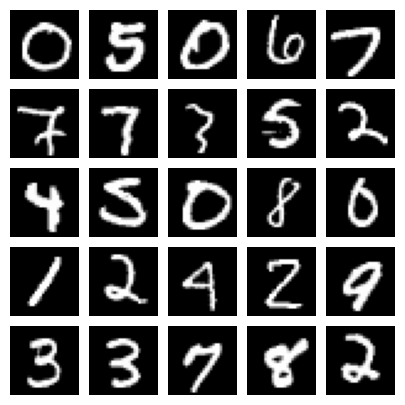

In [3]:
# get 25 sample training images for visualization
dataiter = iter(train_loader)
image = next(dataiter)

num_samples = 25
sample_images = [image[0][i,0] for i in range(num_samples)] 

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

In [4]:
# class Encoder(nn.Module):
    
#     def __init__(self, input_dim=784, hidden_dim=512, latent_dim=256):
#         super(Encoder, self).__init__()

#         self.linear1 = nn.Linear(input_dim, hidden_dim)
#         self.linear2 = nn.Linear(hidden_dim, hidden_dim)
#         self.mean = nn.Linear(hidden_dim, latent_dim)
#         self.var = nn.Linear (hidden_dim, latent_dim)
#         self.LeakyReLU = nn.LeakyReLU(0.2)
#         self.training = True
        
#     def forward(self, x):
#         x = self.LeakyReLU(self.linear1(x))
#         x = self.LeakyReLU(self.linear2(x))

#         mean = self.mean(x)
#         log_var = self.var(x)                     
#         return mean, log_var

In [5]:
# class Decoder(nn.Module):
    
#     def __init__(self, output_dim=784, hidden_dim=512, latent_dim=256):
#         super(Decoder, self).__init__()

#         self.linear2 = nn.Linear(latent_dim, hidden_dim)
#         self.linear1 = nn.Linear(hidden_dim, hidden_dim)
#         self.output = nn.Linear(hidden_dim, output_dim)
#         self.LeakyReLU = nn.LeakyReLU(0.2)
        
#     def forward(self, x):
#         x = self.LeakyReLU(self.linear2(x))
#         x = self.LeakyReLU(self.linear1(x))
        
#         x_hat = torch.sigmoid(self.output(x))
#         return x_hat

## 3. Building VAE architecture
Функція втрат у VAE складається з втрат при відтворенні та розбіжності Кульбака-Лейблера (KL). Розбіжність KL - це метрика, яка використовується для вимірювання відстані між двома розподілами ймовірностей. Розбіжність KL є важливим поняттям у генеративному моделюванні.

In [6]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

Тепер ми створимо простий VAE, який має повністю з'єднані кодери та декодери. Вхідна розмірність - 784, що є сплющеною розмірністю зображень MNIST (28×28). У енкодері вектори середнього значення (μ) та дисперсії (σ²) є нашими векторами варіаційного представлення (розмір=200). Також ми множимо приховану дисперсію на параметр епсилон (ε) для репараметризації перед декодуванням. Це дозволяє нам виконати зворотне розповсюдження і впоратися зі стохастичністю вузлів

Крім того, наш кінцевий вимір енкодера має розмірність 2, яка є векторами μ і σ. Ці неперервні вектори визначають наш розподіл латентного простору, який дозволяє нам робити вибірки зображень у VAE.

In [7]:
class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device=device):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, log_var
        
    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) 
        x_hat = self.decode(z)  
        return x_hat, mean, log_var

In [8]:
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

## 4. Training the model

Модель навчається наступним чином:
- по-перше, вхідні дані кодуються як розподіл у латентному просторі
- по-друге, з цього розподілу вибирається точка з латентного простору
- по-третє, вибіркова точка декодується і обчислюється похибка реконструкції
- нарешті, похибка реконструкції поширюється мережею

In [10]:
def train(model, optimizer, epochs, device, x_dim=784):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(batch_size, x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

In [11]:
train(model, optimizer, epochs=50, device=device)

	Epoch 1 	Average Loss:  180.74479826403382
	Epoch 2 	Average Loss:  161.86594066282345
	Epoch 3 	Average Loss:  157.77955309630633
	Epoch 4 	Average Loss:  154.90160125273894
	Epoch 5 	Average Loss:  152.70358843515234
	Epoch 6 	Average Loss:  151.13910056800395
	Epoch 7 	Average Loss:  149.9719742050553
	Epoch 8 	Average Loss:  148.84643178083263
	Epoch 9 	Average Loss:  148.18854047109767
	Epoch 10 	Average Loss:  147.56073439456387
	Epoch 11 	Average Loss:  146.85823936704404
	Epoch 12 	Average Loss:  146.26513994678632
	Epoch 13 	Average Loss:  145.851355514399
	Epoch 14 	Average Loss:  145.49899321134183
	Epoch 15 	Average Loss:  145.11124530467447
	Epoch 16 	Average Loss:  144.500998001226
	Epoch 17 	Average Loss:  144.26629039936353
	Epoch 18 	Average Loss:  144.13600114774624
	Epoch 19 	Average Loss:  143.60659756821263
	Epoch 20 	Average Loss:  143.5536827003339
	Epoch 21 	Average Loss:  143.22762260016694
	Epoch 22 	Average Loss:  142.81169871335038
	Epoch 23 	Average Loss: 

8337136.728515625

## 5. Generating results

Тепер ми знаємо, що все, що нам потрібно для створення зображення з латентного простору - це два значення з плаваючою комою (середнє та дисперсія). Давайте створимо кілька зображень з латентного простору:

In [12]:
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    plt.title(f'[{mean},{var}]')
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

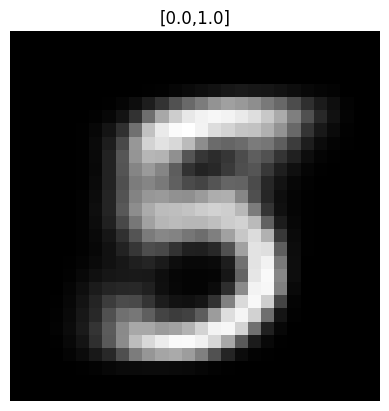

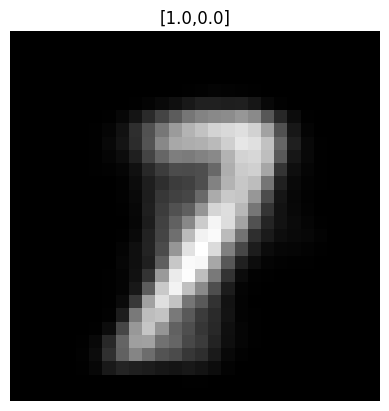

(None, None)

In [13]:
#img1: mean0, var1 / img2: mean1, var0
generate_digit(0.0, 1.0), generate_digit(1.0, 0.0)

Більш вражаючий вигляд прихованого простору

In [14]:
def plot_latent_space(model, scale=5.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

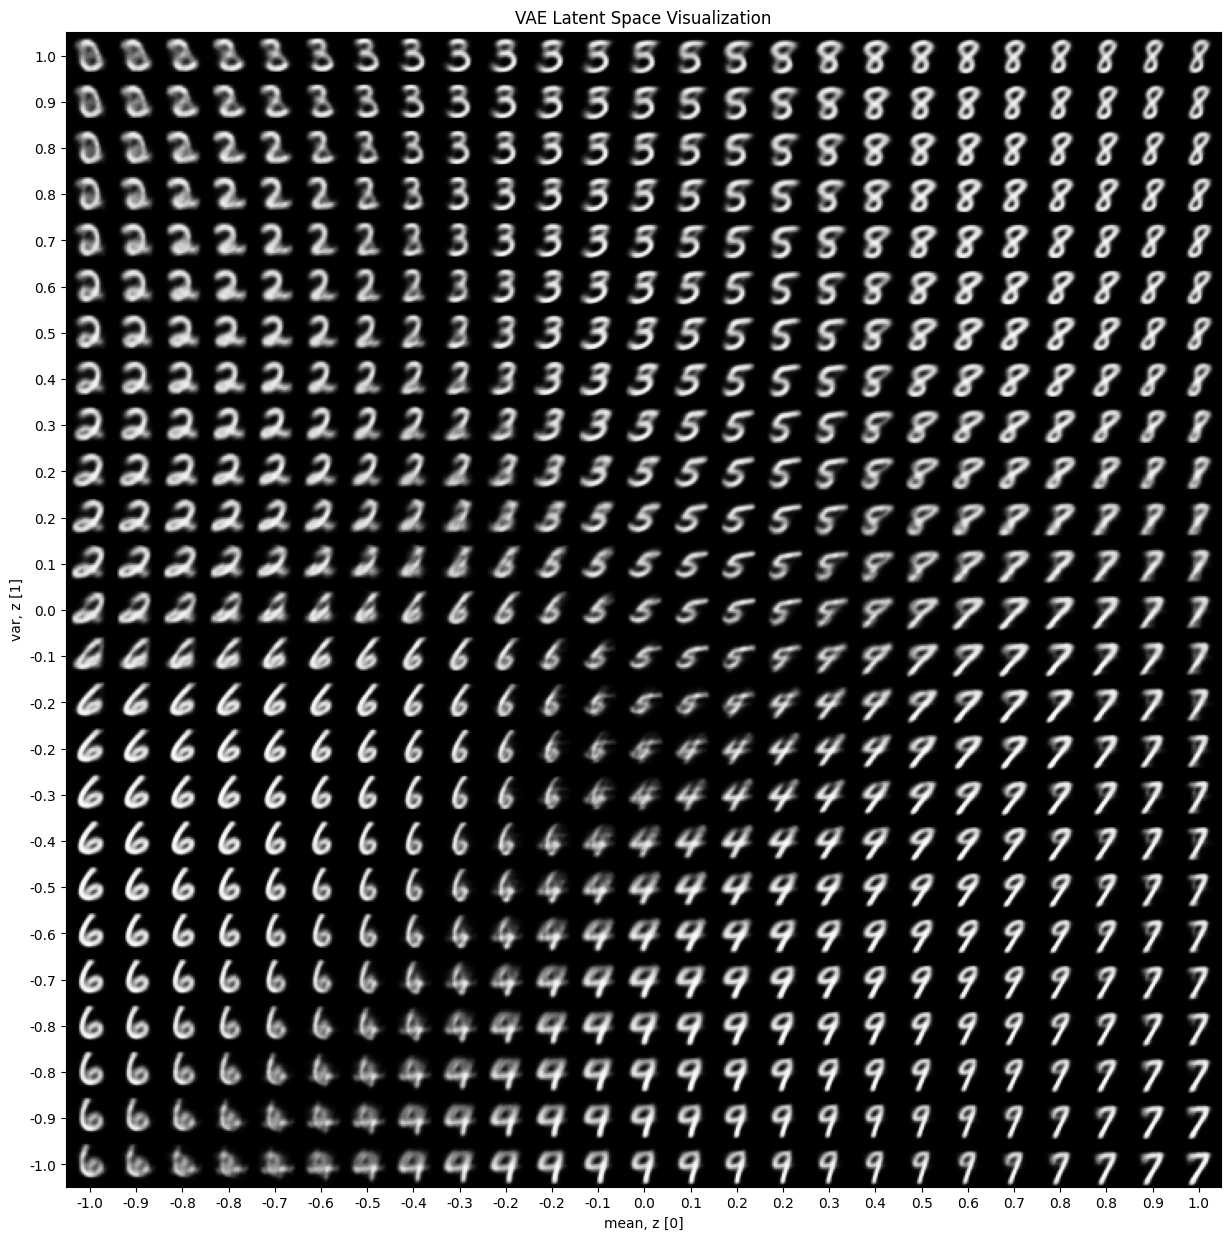

In [15]:
plot_latent_space(model, scale=1.0)

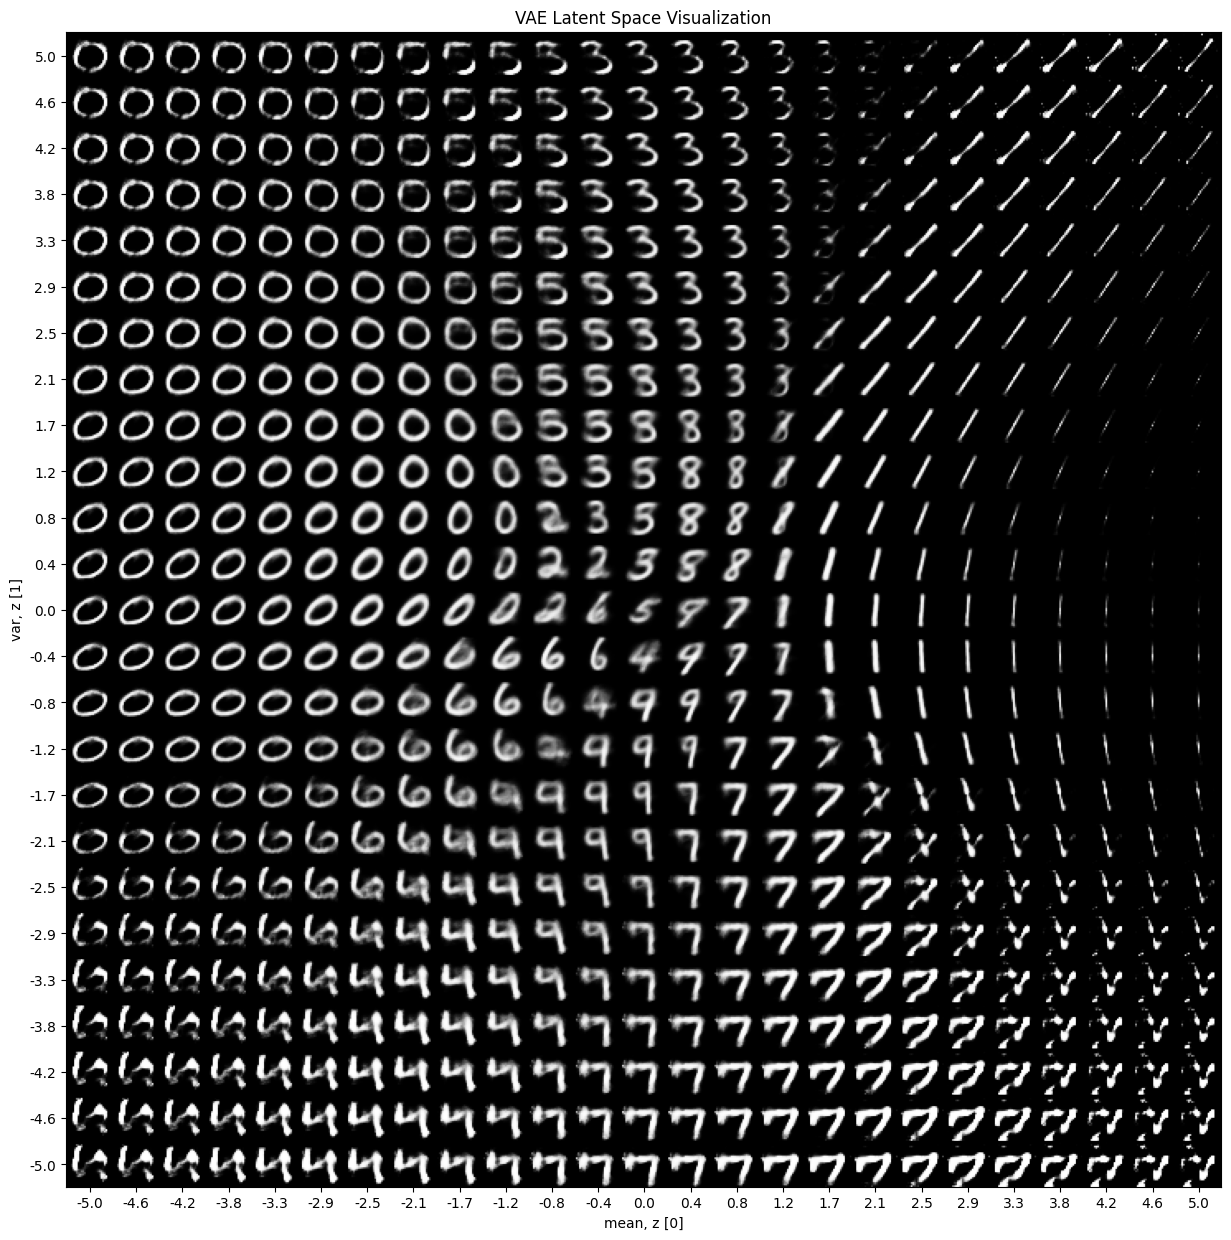

In [16]:
plot_latent_space(model, scale=5.0)

Тепер ми бачимо діапазон значень середнього та дисперсії, в якому лежить більшість зображень цифр. Тепер ми знаємо, як побудувати простий VAE з нуля, зробити вибірку зображень і візуалізувати латентний простір.

**Приклад згенерованих чисел архітектурою GAN**

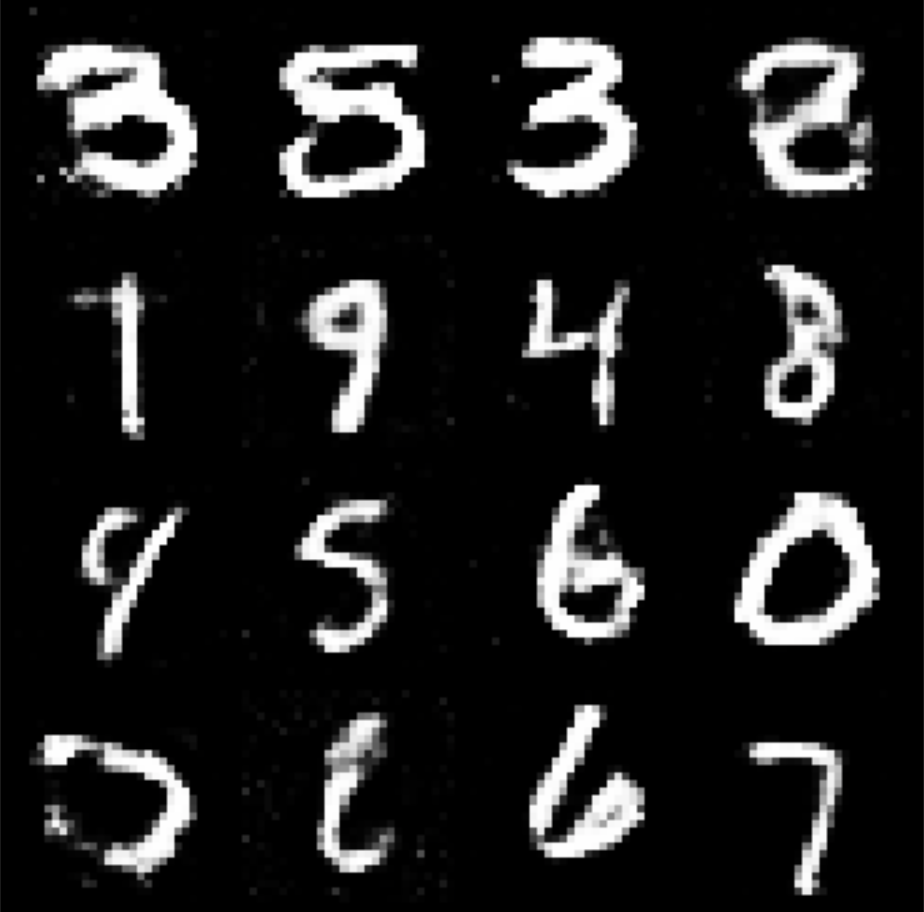

## 6. Conclusions

- VAE - це автоенкодер, розподіл якого під час навчання регуляризується для того, щоб його латентний простір мав хороші властивості, які дозволяють генерувати нові дані. Крім того, термін "варіаційний" походить від тісного зв'язку, який існує між регуляризацією та методом варіаційного виведення в статистиці.
- Кодування - цу процес, який створює представлення "нових ознак" із представлення "старих ознак" (шляхом виділення або вилучення), а декодування - зворотний процес. Зменшення розмірності можна інтерпретувати як стиснення даних, де енкодер стискає дані (з початкового простору до закодованого простору, який також називають латентним простором), тоді як декодер розпаковує їх. Звичайно, залежно від початкового розподілу даних, розміру латентного простору та визначення кодера, це стиснення може бути з втратами, тобто частина інформації втрачається під час процесу кодування і не може бути відновлена при декодуванні.
- VAE можна визначити як автоенкодер, навчання якого регулюється, щоб уникнути перенавчання і гарантувати, що латентний простір має хороші властивості, які уможливлюють генеративний процес.
- через перенавчання латентний простір автоенкодера може бути вкрай нерегулярним (близькі точки латентного простору можуть давати дуже різні декодовані дані, деяка точка латентного простору може давати безглуздий зміст після декодування) і, таким чином, ми не можемо визначити генеративний процес, який просто полягає у вибірці точки з латентного простору та її проходженні через декодер для отримання нових даних
- варіаційні автокодери (VAE) - вирішують проблему нерегулярності латентного простору, змушуючи кодер повертати розподіл по латентному простору замість однієї точки і додаючи до функції втрат член регуляризації над цим поверненим розподілом, щоб забезпечити кращу організацію латентного простору
- припускаючи просту базову ймовірнісну модель для опису наших даних, досить інтуїтивно зрозумілу функцію втрат VAE, що складається з члена реконструкції та члена регуляризації, можна ретельно вивести, використовуючи, зокрема, статистичну техніку варіаційного виведення (звідси і назва "варіаційні" автокодери).
- Основним недоліком VAE є розмитість результатів, які вони генерують. Моделі VAE мають тенденцію створювати нереалістичні, розмиті вибірки. Це пов'язано зі способом відновлення розподілу даних та обчислення функцій втрат, тому вони програють архітектурі GAN у випадку генерації зображень
- Загалом, GAN, як правило, ширше використовуються для створення зображень, в той час як VAE більше застосовуються для аналізу сигналів

# END